In [1]:
import pandas as pd
import os
import numpy as np
import optuna
from sklearn.preprocessing import StandardScaler
# We are going to compare two different regression models here
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Data preparation

In [2]:
# --------------------
# Load and Preprocess
# --------------------
sfeatures = ['s' + str(i) for i in range(1, 22)]
col_names = ['unit_no', 'time', 'op1', 'op2', 'op3'] + sfeatures

data_train = pd.read_csv('./CMAPSSData/train_FD001.txt', sep=r'\s+', header=None, names=col_names)
data_test = pd.read_csv('./CMAPSSData/test_FD001.txt', sep=r'\s+', header=None, names=col_names)
RUL_labels = pd.read_csv('./CMAPSSData/RUL_FD001.txt', sep=r'\s+', header=None, names=['RUL'])

# Add RUL to train
max_times = data_train.groupby('unit_no')['time'].max().reset_index()
data_train = data_train.merge(max_times, on='unit_no', suffixes=('', '_max'))
data_train['RUL_calc'] = data_train['time_max'] - data_train['time']
data_train.drop(['time', 'time_max'], axis=1, inplace=True)

# Add RUL to test
RUL_labels['unit_no'] = RUL_labels.index + 1
max_times_test = data_test.groupby('unit_no')['time'].max().reset_index()
data_test = data_test.merge(max_times_test, on='unit_no', suffixes=('', '_max'))
data_test = data_test.merge(RUL_labels, on='unit_no')
data_test['RUL_calc'] = data_test['time_max'] - data_test['time'] + data_test['RUL']
data_test.drop(['time', 'time_max', 'RUL'], axis=1, inplace=True)

feature_cols = ['op1', 'op2', 'op3'] + sfeatures

In [3]:
# Normalize
scaler = StandardScaler()
data_train[feature_cols] = scaler.fit_transform(data_train[feature_cols])
data_test[feature_cols] = scaler.transform(data_test[feature_cols])
data_train.head()

,unit_no,op1,op2,op3,s1,s2,s3,s4,s5,s6,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL_calc
0,1,-0.315980,-1.372953,0.0,0.0,-1.721725,-0.134255,-0.925936,-1.776357e-15,0.141683,...,-1.058890,-0.269071,-0.603816,-1.387779e-17,-0.781710,0.0,0.0,1.348493,1.194427,191
1,1,0.872722,-1.031720,0.0,0.0,-1.061780,0.211528,-0.643726,-1.776357e-15,0.141683,...,-0.363646,-0.642845,-0.275852,-1.387779e-17,-0.781710,0.0,0.0,1.016528,1.236922,190
2,1,-1.961874,1.015677,0.0,0.0,-0.661813,-0.413166,-0.525953,-1.776357e-15,0.141683,...,-0.919841,-0.551629,-0.649144,-1.387779e-17,-2.073094,0.0,0.0,0.739891,0.503423,189
3,1,0.324090,-0.008022,0.0,0.0,-0.661813,-1.261314,-0.784831,-1.776357e-15,0.141683,...,-0.224597,-0.520176,-1.971665,-1.387779e-17,-0.781710,0.0,0.0,0.352598,0.777792,188
4,1,-0.864611,-0.690488,0.0,0.0,-0.621816,-1.251528,-0.301518,-1.776357e-15,0.141683,...,-0.780793,-0.521748,-0.339845,-1.387779e-17,-0.136018,0.0,0.0,0.463253,1.059552,187


In [4]:
# --------------------
# Proper Train/Validation Split by unit_no
# --------------------
train_ids, valid_ids = train_test_split(data_train['unit_no'].unique(), test_size=0.2, random_state=42)
train_df = data_train[data_train['unit_no'].isin(train_ids)]
valid_df = data_train[data_train['unit_no'].isin(valid_ids)]

# XGBoost regressor

In [5]:
# --------------------
# Sliding Window
# --------------------
def create_sliding_window(df, window_length=30):
    x, y, unit_id = [], [], []
    for unit in df['unit_no'].unique():
        unit_df = df[df['unit_no'] == unit]
        for i in range(len(unit_df) - window_length):
            window = unit_df.iloc[i:i + window_length][feature_cols].values
            label = unit_df.iloc[i + window_length]['RUL_calc']
            uid = unit_df.iloc[i + window_length]['unit_no']
            unit_id.append(uid)
            x.append(window)
            y.append(label)
    return np.array(x), np.array(y), np.asarray(unit_id)

x_train, y_train, uid_train = create_sliding_window(train_df)
x_valid, y_valid, uid_valid = create_sliding_window(valid_df)
x_test, y_test, uid_test = create_sliding_window(data_test)

# Flatten
X_train = x_train.reshape(x_train.shape[0], -1)
X_valid = x_valid.reshape(x_valid.shape[0], -1)
X_test = x_test.reshape(x_test.shape[0], -1)

In [6]:
print(f'shapes of x_train, X_train, y_train = {x_train.shape, X_train.shape, y_train.shape}')
print(f'shapes of x_valid, X_valid, y_valid = {x_valid.shape, X_valid.shape, y_valid.shape}')
print(f'shapes of x_valid, X_valid, y_valid = {x_test.shape, X_test.shape, y_test.shape}')

shapes of x_train, X_train, y_train = ((14161, 30, 24), (14161, 720), (14161,))
shapes of x_valid, X_valid, y_valid = ((3470, 30, 24), (3470, 720), (3470,))
shapes of x_valid, X_valid, y_valid = ((10096, 30, 24), (10096, 720), (10096,))


In [7]:
# --------------------
# Optimization and Training
# --------------------
def optimize_quantile_model(X_train, y_train, X_valid, y_valid, trial, q):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 40, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'verbosity': 0
    }

    model = XGBRegressor(objective="reg:quantileerror", 
                         quantile_alpha=q,
                         **params)
    
    model.fit(
            X_train, y_train,
            eval_set = [(X_valid, y_valid)],
            verbose=False
    )

    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

# Run for all quantiles
quantiles = [0.05, 0.5, 0.95]
#uantiles = [0.5]
models = {}

for q in quantiles:
    print(f"Optimizing quantile {q}")
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: optimize_quantile_model(X_train, y_train, X_valid, y_valid, trial, q), n_trials=50)

    best_params = study.best_params
    
    xgb_regressor = XGBRegressor(**best_params,
                                 objective="reg:quantileerror", 
                                 quantile_alpha = q
                                )
    xgb_regressor.fit(X_train, y_train)
    y_pred = xgb_regressor.predict(X_test)

    models[q] = best_params
print(f'final output = {models}')

[I 2025-06-11 09:44:16,192] A new study created in memory with name: no-name-18342154-f91f-4a9a-9841-db5f4332d32e


Optimizing quantile 0.05


[I 2025-06-11 09:44:18,598] Trial 0 finished with value: 41.41229758227743 and parameters: {'n_estimators': 46, 'max_depth': 5, 'learning_rate': 0.17547669845547817, 'subsample': 0.7045408173806313, 'colsample_bytree': 0.662052141938176}. Best is trial 0 with value: 41.41229758227743.
[I 2025-06-11 09:44:24,061] Trial 1 finished with value: 54.46910867126342 and parameters: {'n_estimators': 84, 'max_depth': 5, 'learning_rate': 0.03594289532663201, 'subsample': 0.8666191892912773, 'colsample_bytree': 0.9146892809353361}. Best is trial 0 with value: 41.41229758227743.
[I 2025-06-11 09:44:29,876] Trial 2 finished with value: 64.43258610530958 and parameters: {'n_estimators': 41, 'max_depth': 9, 'learning_rate': 0.0402039461564691, 'subsample': 0.8634891316149804, 'colsample_bytree': 0.772863447238863}. Best is trial 0 with value: 41.41229758227743.
[I 2025-06-11 09:44:38,748] Trial 3 finished with value: 38.354415802850845 and parameters: {'n_estimators': 75, 'max_depth': 9, 'learning_rat

[I 2025-06-11 09:47:04,435] Trial 29 finished with value: 35.65943010011285 and parameters: {'n_estimators': 95, 'max_depth': 5, 'learning_rate': 0.28215399144829595, 'subsample': 0.6718632235318431, 'colsample_bytree': 0.6558011627667657}. Best is trial 21 with value: 34.273167124625715.
[I 2025-06-11 09:47:10,038] Trial 30 finished with value: 38.058669308635274 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.13224666079142133, 'subsample': 0.6979035644038292, 'colsample_bytree': 0.6178395027561585}. Best is trial 21 with value: 34.273167124625715.
[I 2025-06-11 09:47:15,128] Trial 31 finished with value: 34.4629246644869 and parameters: {'n_estimators': 97, 'max_depth': 7, 'learning_rate': 0.297377889652758, 'subsample': 0.5328475882997459, 'colsample_bytree': 0.595500028018232}. Best is trial 21 with value: 34.273167124625715.
[I 2025-06-11 09:47:19,897] Trial 32 finished with value: 33.85668206634886 and parameters: {'n_estimators': 100, 'max_depth': 7, 'l

Optimizing quantile 0.5


[I 2025-06-11 09:49:27,353] Trial 0 finished with value: 19.242568055976193 and parameters: {'n_estimators': 89, 'max_depth': 5, 'learning_rate': 0.12843169219313133, 'subsample': 0.7663428236625457, 'colsample_bytree': 0.8578870906646269}. Best is trial 0 with value: 19.242568055976193.
[I 2025-06-11 09:49:42,209] Trial 1 finished with value: 19.903904498104403 and parameters: {'n_estimators': 63, 'max_depth': 9, 'learning_rate': 0.18144995178921888, 'subsample': 0.662407880877339, 'colsample_bytree': 0.823142902719409}. Best is trial 0 with value: 19.242568055976193.
[I 2025-06-11 09:49:51,106] Trial 2 finished with value: 19.275104117676918 and parameters: {'n_estimators': 73, 'max_depth': 7, 'learning_rate': 0.12131675983909423, 'subsample': 0.9631812691237027, 'colsample_bytree': 0.8772797110065857}. Best is trial 0 with value: 19.242568055976193.
[I 2025-06-11 09:50:05,294] Trial 3 finished with value: 20.13579547743203 and parameters: {'n_estimators': 60, 'max_depth': 9, 'learni

[I 2025-06-11 09:53:02,382] Trial 29 finished with value: 19.239878883706112 and parameters: {'n_estimators': 88, 'max_depth': 5, 'learning_rate': 0.1361647018828225, 'subsample': 0.6853500152379157, 'colsample_bytree': 0.676491279759424}. Best is trial 21 with value: 19.044470201660303.
[I 2025-06-11 09:53:10,919] Trial 30 finished with value: 18.985998378801415 and parameters: {'n_estimators': 98, 'max_depth': 6, 'learning_rate': 0.11897090785120107, 'subsample': 0.6176554056864532, 'colsample_bytree': 0.7350016803998634}. Best is trial 30 with value: 18.985998378801415.
[I 2025-06-11 09:53:17,459] Trial 31 finished with value: 19.201253477666494 and parameters: {'n_estimators': 97, 'max_depth': 6, 'learning_rate': 0.12224345343433318, 'subsample': 0.6208561956960461, 'colsample_bytree': 0.7361687823007494}. Best is trial 30 with value: 18.985998378801415.
[I 2025-06-11 09:53:24,238] Trial 32 finished with value: 19.25077166402503 and parameters: {'n_estimators': 93, 'max_depth': 6, 

Optimizing quantile 0.95


[I 2025-06-11 09:56:18,641] Trial 0 finished with value: 73.14357515054752 and parameters: {'n_estimators': 71, 'max_depth': 7, 'learning_rate': 0.034445923004289274, 'subsample': 0.7405260459581609, 'colsample_bytree': 0.5020712061359165}. Best is trial 0 with value: 73.14357515054752.
[I 2025-06-11 09:56:21,204] Trial 1 finished with value: 56.63667056725417 and parameters: {'n_estimators': 82, 'max_depth': 3, 'learning_rate': 0.25755051038839916, 'subsample': 0.6310315192269483, 'colsample_bytree': 0.5372544650168829}. Best is trial 1 with value: 56.63667056725417.
[I 2025-06-11 09:56:30,115] Trial 2 finished with value: 66.44988424427571 and parameters: {'n_estimators': 98, 'max_depth': 9, 'learning_rate': 0.028172061407842994, 'subsample': 0.7373467898960023, 'colsample_bytree': 0.5395690423401691}. Best is trial 1 with value: 56.63667056725417.
[I 2025-06-11 09:56:32,304] Trial 3 finished with value: 54.18680839937084 and parameters: {'n_estimators': 55, 'max_depth': 5, 'learning

[I 2025-06-11 09:58:47,338] Trial 29 finished with value: 51.97622274953969 and parameters: {'n_estimators': 71, 'max_depth': 6, 'learning_rate': 0.2215898297063523, 'subsample': 0.7732195673698868, 'colsample_bytree': 0.8518105807789105}. Best is trial 19 with value: 42.256165888536216.
[I 2025-06-11 09:58:51,604] Trial 30 finished with value: 49.27119726488844 and parameters: {'n_estimators': 74, 'max_depth': 7, 'learning_rate': 0.18154778478834227, 'subsample': 0.7266842909810178, 'colsample_bytree': 0.6114039866919254}. Best is trial 19 with value: 42.256165888536216.
[I 2025-06-11 09:58:59,127] Trial 31 finished with value: 41.815512422010606 and parameters: {'n_estimators': 78, 'max_depth': 10, 'learning_rate': 0.2990281559799618, 'subsample': 0.5680954686338603, 'colsample_bytree': 0.7186387309778797}. Best is trial 31 with value: 41.815512422010606.
[I 2025-06-11 09:59:05,116] Trial 32 finished with value: 43.872624958282934 and parameters: {'n_estimators': 81, 'max_depth': 9, 

final output = {0.05: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2800379608945074, 'subsample': 0.5066410120140739, 'colsample_bytree': 0.5356636494795903}, 0.5: {'n_estimators': 98, 'max_depth': 7, 'learning_rate': 0.08439008521074558, 'subsample': 0.647607494717152, 'colsample_bytree': 0.7014241510243016}, 0.95: {'n_estimators': 85, 'max_depth': 10, 'learning_rate': 0.2562794619131016, 'subsample': 0.5971084748575561, 'colsample_bytree': 0.7566493465639283}}


In [8]:
# --------------------
# Predict on Test Set
# --------------------
quantiles = [0.05, 0.5, 0.95]
ypreds = {}
for q in quantiles:
    xgb_regressor = XGBRegressor(
        objective="reg:quantileerror", 
        quantile_alpha=q,
        **models[q]
    )
    xgb_regressor.fit(X_train, y_train)
    y_pred = xgb_regressor.predict(X_test)
    ypreds[q] = y_pred
    print(f'predictions for quantile {q} are {y_pred}')



predictions for quantile 0.05 are [101.1452    72.57021   76.00291  ...  13.7031    19.792786  13.909708]
predictions for quantile 0.5 are [146.26158  136.60692  137.4771   ...  23.805613  23.986979  25.694817]
predictions for quantile 0.95 are [209.2664   190.93509  212.94473  ...  30.441378  43.831886  45.099903]


In [18]:
uid_test

array([  1.,   2.,   2., ..., 100., 100., 100.], shape=(10096,))

In [20]:
df_preds = pd.DataFrame({'unit_no':uid_test, 
                         'RUL_pred05':ypreds[0.05], 
                         'RUL_pred5':ypreds[0.5], 
                         'RUL_pred95':ypreds[0.95],
                         'RUL_true':y_test
                        })
df_preds.to_csv('final_results.txt', index=False)

In [21]:
df_preds.head()

,unit_no,RUL_pred05,RUL_pred5,RUL_pred95,RUL_true
0,1.0,101.145203,146.261581,209.266403,112.0
1,2.0,72.570213,136.606918,190.935089,116.0
2,2.0,76.002907,137.477097,212.944733,115.0
3,2.0,73.526527,134.918915,174.050110,114.0
4,2.0,82.506424,129.390640,203.851974,113.0


In [22]:
f =open('outfile.txt','w')
f.write('%s' %(models))
f.write('\n')
for q in quantiles:
    f_quant =open('outfile_%s.txt' %(q),'w')
    for ypred in ypreds[q]:
        f_quant.write('%s \t %s\n' %(q, ypred))
    f_quant.close()
f.close()

In [23]:
RUL_per_unit = df_preds.groupby('unit_no').last().reset_index()
RUL_per_unit = RUL_per_unit.merge(RUL_labels, on ='unit_no').reset_index()
RUL_per_unit = RUL_per_unit.sort_values(by=['RUL'])
RUL_per_unit.to_csv('RUL_per_unit.txt', index=False)

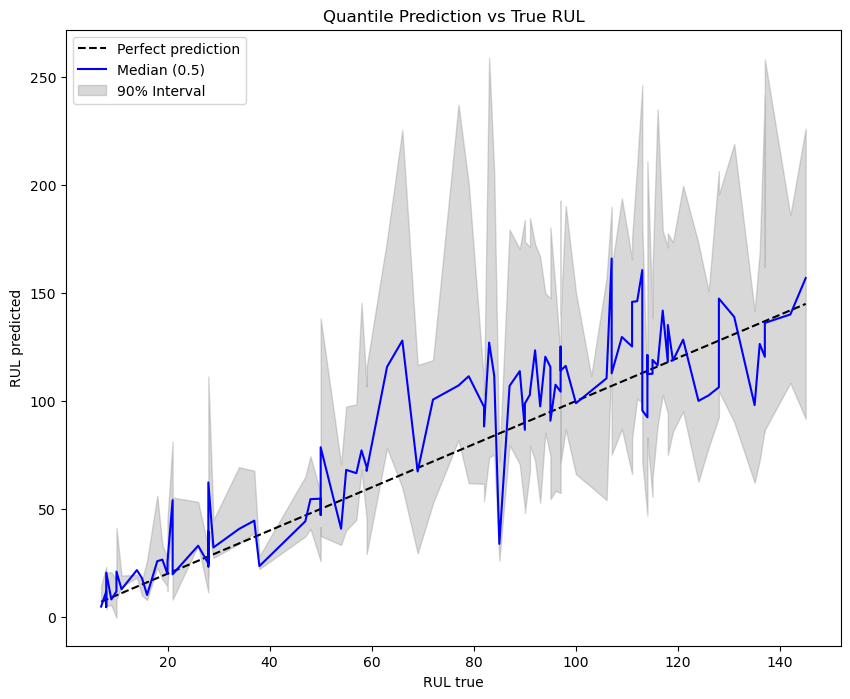

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
#plt.plot(np.arange(len(RUL_per_unit['RUL'])),RUL_per_unit['RUL'], label='True RUL', color='black', alpha=0.5)
#plt.plot(np.arange(len(RUL_per_unit['RUL'])),RUL_per_unit['RUL_pred5'], label='Median (0.5)', color='blue')
#plt.fill_between(np.arange(len(RUL_per_unit['RUL'])), RUL_per_unit['RUL_pred05'], RUL_per_unit['RUL_pred95'], color='gray', alpha=0.3, label='90% Interval')

#plt.plot(np.arange(len(RUL_per_unit['RUL'])),RUL_per_unit['RUL'], label='True RUL', color='black', alpha=0.5)
plt.plot(RUL_per_unit['RUL'],RUL_per_unit['RUL'], label='Perfect prediction', color='black', linestyle = '--')
plt.plot(RUL_per_unit['RUL'],RUL_per_unit['RUL_pred5'], label='Median (0.5)', color='blue')
plt.fill_between(RUL_per_unit['RUL'], RUL_per_unit['RUL_pred05'], RUL_per_unit['RUL_pred95'], color='gray', alpha=0.3, label='90% Interval')

plt.legend()
plt.xlabel('RUL true')
plt.ylabel('RUL predicted')
plt.title('Quantile Prediction vs True RUL')
plt.savefig('final_predictions.png')

# Prediction Matrices

In [32]:
#1. Coverage (PICP – Prediction Interval Coverage Probability)
#Check how often the true value falls within your predicted interval (e.g. between the 5th and 95th percentile).

def picp(y_true, q_lower, q_upper):
    within_interval = np.logical_and(y_true >= q_lower, y_true <= q_upper)
    return np.mean(within_interval)  # Should ideally be close to 0.90 for [0.05, 0.95]

#2. Interval Width (MPIW – Mean Prediction Interval Width)
#How wide are your prediction intervals? Narrower intervals are better if coverage is still acceptable.

def mpiw(q_lower, q_upper):
    return np.mean(q_upper - q_lower)

#3. Quantile Loss (Pinball Loss)
#This directly evaluates how well your model estimates each quantile.

def quantile_loss(y_true, y_pred, q):
    return np.mean(np.maximum(q * (y_true - y_pred), (q - 1) * (y_true - y_pred)))

In [40]:
print(f'Prediction Interval Coverage Probability = {picp(RUL_per_unit['RUL'], RUL_per_unit['RUL_pred05'], RUL_per_unit['RUL_pred95'])}')
print(f'Mean Prediction Interval Width = {mpiw(RUL_per_unit['RUL_pred05'], RUL_per_unit['RUL_pred95'])}')
print(f'Quantile Loss (Pinball Loss) for q = 0.5 = {quantile_loss(RUL_per_unit['RUL'], RUL_per_unit['RUL_pred5'], 0.5)}')
print(f'Quantile Loss (Pinball Loss) for q = 0.05 = {quantile_loss(RUL_per_unit['RUL'], RUL_per_unit['RUL_pred05'], 0.05)}')
print(f'Quantile Loss (Pinball Loss) for q = 0.95 = {quantile_loss(RUL_per_unit['RUL'], RUL_per_unit['RUL_pred95'], 0.95)}')

Prediction Interval Coverage Probability = 0.84
Mean Prediction Interval Width = 73.39614868164062
Quantile Loss (Pinball Loss) for q = 0.5 = 7.21262894153595
Quantile Loss (Pinball Loss) for q = 0.05 = 2.1856367536038164
Quantile Loss (Pinball Loss) for q = 0.95 = 2.945105307102205


mpiw = 73.39614868164062


quantile loss = 7.21262894153595


quantile loss = 2.1856367536038164


quantile loss = 2.945105307102205
